In [1]:
# General libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Neural network libraries
import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow import keras

# Machine Learning libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, BatchNormalization, Embedding
from keras.layers.recurrent import LSTM
#Visualization
from matplotlib import pyplot
import matplotlib.pyplot as plt


['Volume IBM', 'Volume GOLD', 'Volume NSQ', 'Volume WTI', 'SO IBM',
       'CCI IBM', 'RSI IBM', 'ULTOSC IBM', 'CCI WTI', 'CCI GOLD',
       'aroonup GOLD', 'ULTOSC GOLD', 'SO NSQ', 'CCI NSQ', 'aroondown NSQ',
       'aroonup NSQ', 'ULTOSC NSQ']

## Preliminary work on the dataset

In [2]:
yahoo_df = pd.read_csv("../data/NSQ.csv")
#yahoo_df = yahoo_df.set_index("Date")
yahoo_df = yahoo_df.set_index("Date")

### Cleaning

In [3]:

X = yahoo_df[['ROC_30', '4 Day ROI', 'EMA_12', 'MACD_12_26_9', 'SRSI_30',
       'Williams_14', 'ATR_14', 'Previous_differenced']]
#X = yahoo_df.drop(columns=["Up down"])

y = yahoo_df["Up down"]



In [4]:
X

,ROC_30,4 Day ROI,EMA_12,MACD_12_26_9,SRSI_30,Williams_14,ATR_14,Previous_differenced
Date,,,,,,,,
2001-04-24,5.913661,-0.026366,1754.226325,14.845864,0.921375,-32.389937,129.530633,-0.068851
2001-04-25,2.299495,-0.066291,1764.960736,19.312162,0.875157,-28.130081,123.659882,-0.015393
2001-04-26,1.226819,-0.091886,1766.351392,18.602712,0.858921,-39.821429,119.305231,0.018425
2001-04-27,7.933689,0.002199,1775.066563,21.743711,0.951489,-31.182796,111.664534,-0.027412
2001-04-30,12.172845,0.042155,1789.133245,27.426901,1.000000,-26.100000,109.509262,0.027621
...,...,...,...,...,...,...,...,...
2022-03-22,0.647333,0.050240,13992.630216,-62.553224,0.414869,-2.103907,430.511541,0.019524
2022-03-23,-1.951203,0.023757,14062.533260,-21.673629,0.379605,-13.954487,405.276669,0.019728
2022-03-24,-1.825345,0.047423,14170.412758,35.869343,0.380847,-0.328632,396.073113,-0.014126


In [5]:
X.columns

Index(['ROC_30', '4 Day ROI', 'EMA_12', 'MACD_12_26_9', 'SRSI_30',
       'Williams_14', 'ATR_14', 'Previous_differenced'],
      dtype='object')

In [6]:
def normalize(df):
    #df = data
    for column in df:
        df[column]=((df[column]-df[column].mean())/df[column].std())
    return df

# Train, test, val

In [7]:
# Split in 80/20 the dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.20, shuffle=False)

In [8]:
X_train = normalize(X_train).values
X_test = normalize(X_test).values

# Normalize

In [9]:
y_train = y_train.values
y_test = y_test.values

In [10]:
#X_train = normalize(X_train)
#X_test = normalize(X_test)

In [11]:
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


# Model

In [12]:
def model_(X,optimizer,activation,loss,metrics):
    #optimizer=str(optimizer)
    #activation=str(activation)
    #loss=str(loss)
    # Define the Model

    # Instantiate the Sequential Model
    model = Sequential()
    model.add(LSTM(units=512, activation="sigmoid",return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(units=256, activation="sigmoid",return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(units=128, activation="sigmoid",return_sequences=False))
    model.add(Dropout(0.4))
    # Add a Dense layer
    model.add(Dense(64, activation="sigmoid"))
    # Add the output layer
    model.add(Dense(1, activation="sigmoid"))

    # Compiling the model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

In [13]:
# Define the Model
metrics=[
    keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.49),
    keras.metrics.BinaryCrossentropy(),
    ]

esm = EarlyStopping(monitor = 'val_binary_accuracy',patience=50)
# Set the optimizer
opt = keras.optimizers.Adam(learning_rate = 0.001)

In [14]:
batch_size = int(round(X_train.shape[0]*0.1))
# # Training the model to the training dataset
model=model_(X_train, opt,'relu','binary_crossentropy',metrics) 
history=model.fit(X_train, y_train, batch_size= batch_size, epochs=1000, verbose=1, shuffle=False,validation_split=0.10)

Epoch 1/1000
10/10 [==============================] - 8s 232ms/step - loss: 0.6974 - binary_accuracy: 0.5129 - binary_crossentropy: 0.6974 - val_loss: 0.6792 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6792
Epoch 2/1000
10/10 [==============================] - 1s 117ms/step - loss: 0.6942 - binary_accuracy: 0.5355 - binary_crossentropy: 0.6942 - val_loss: 0.6757 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6757
Epoch 3/1000
10/10 [==============================] - 1s 114ms/step - loss: 0.6955 - binary_accuracy: 0.5355 - binary_crossentropy: 0.6955 - val_loss: 0.6771 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6771
Epoch 4/1000
10/10 [==============================] - 1s 74ms/step - loss: 0.6943 - binary_accuracy: 0.5349 - binary_crossentropy: 0.6943 - val_loss: 0.6766 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6766
Epoch 5/1000
10/10 [==============================] - 1s 57ms/step - loss: 0.6953 - binary_accuracy: 0.5352 - bin

Epoch 38/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.6972 - binary_accuracy: 0.5352 - binary_crossentropy: 0.6972 - val_loss: 0.6751 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6751
Epoch 39/1000
10/10 [==============================] - 1s 60ms/step - loss: 0.7001 - binary_accuracy: 0.5352 - binary_crossentropy: 0.7001 - val_loss: 0.6750 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6750
Epoch 40/1000
10/10 [==============================] - 1s 60ms/step - loss: 0.6991 - binary_accuracy: 0.5349 - binary_crossentropy: 0.6991 - val_loss: 0.6754 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6754
Epoch 41/1000
10/10 [==============================] - 1s 54ms/step - loss: 0.6961 - binary_accuracy: 0.5360 - binary_crossentropy: 0.6961 - val_loss: 0.6758 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6758
Epoch 42/1000
10/10 [==============================] - 1s 57ms/step - loss: 0.6955 - binary_accuracy: 0.5352 - b

Epoch 75/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.7006 - binary_accuracy: 0.5362 - binary_crossentropy: 0.7006 - val_loss: 0.6795 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6795
Epoch 76/1000
10/10 [==============================] - 1s 60ms/step - loss: 0.6997 - binary_accuracy: 0.5397 - binary_crossentropy: 0.6997 - val_loss: 0.6804 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6804
Epoch 77/1000
10/10 [==============================] - 1s 57ms/step - loss: 0.7021 - binary_accuracy: 0.5281 - binary_crossentropy: 0.7021 - val_loss: 0.6800 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6800
Epoch 78/1000
10/10 [==============================] - 1s 58ms/step - loss: 0.6993 - binary_accuracy: 0.5281 - binary_crossentropy: 0.6993 - val_loss: 0.6801 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6801
Epoch 79/1000
10/10 [==============================] - 1s 61ms/step - loss: 0.7016 - binary_accuracy: 0.5302 - b

Epoch 112/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.7021 - binary_accuracy: 0.5412 - binary_crossentropy: 0.7021 - val_loss: 0.6969 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6969
Epoch 113/1000
10/10 [==============================] - 1s 64ms/step - loss: 0.7026 - binary_accuracy: 0.5323 - binary_crossentropy: 0.7026 - val_loss: 0.7001 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7001
Epoch 114/1000
10/10 [==============================] - 1s 67ms/step - loss: 0.7009 - binary_accuracy: 0.5352 - binary_crossentropy: 0.7009 - val_loss: 0.6995 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6995
Epoch 115/1000
10/10 [==============================] - 1s 58ms/step - loss: 0.7021 - binary_accuracy: 0.5315 - binary_crossentropy: 0.7021 - val_loss: 0.7015 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7015
Epoch 116/1000
10/10 [==============================] - 1s 58ms/step - loss: 0.7022 - binary_accuracy: 0.530

Epoch 149/1000
10/10 [==============================] - 1s 75ms/step - loss: 0.7001 - binary_accuracy: 0.5328 - binary_crossentropy: 0.7001 - val_loss: 0.7141 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7141
Epoch 150/1000
10/10 [==============================] - 1s 64ms/step - loss: 0.7013 - binary_accuracy: 0.5344 - binary_crossentropy: 0.7013 - val_loss: 0.7125 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7125
Epoch 151/1000
10/10 [==============================] - 1s 60ms/step - loss: 0.6978 - binary_accuracy: 0.5341 - binary_crossentropy: 0.6978 - val_loss: 0.7050 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7050
Epoch 152/1000
10/10 [==============================] - 1s 67ms/step - loss: 0.6965 - binary_accuracy: 0.5349 - binary_crossentropy: 0.6965 - val_loss: 0.6986 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6986
Epoch 153/1000
10/10 [==============================] - 1s 71ms/step - loss: 0.6967 - binary_accuracy: 0.534

Epoch 186/1000
10/10 [==============================] - 1s 56ms/step - loss: 0.6995 - binary_accuracy: 0.5352 - binary_crossentropy: 0.6995 - val_loss: 0.7363 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7363
Epoch 187/1000
10/10 [==============================] - 1s 56ms/step - loss: 0.6976 - binary_accuracy: 0.5360 - binary_crossentropy: 0.6976 - val_loss: 0.7184 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7184
Epoch 188/1000
10/10 [==============================] - 1s 65ms/step - loss: 0.6953 - binary_accuracy: 0.5299 - binary_crossentropy: 0.6953 - val_loss: 0.7024 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7024
Epoch 189/1000
10/10 [==============================] - 1s 61ms/step - loss: 0.6933 - binary_accuracy: 0.5347 - binary_crossentropy: 0.6933 - val_loss: 0.7000 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7000
Epoch 190/1000
10/10 [==============================] - 1s 57ms/step - loss: 0.7056 - binary_accuracy: 0.535

Epoch 223/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.6942 - binary_accuracy: 0.5352 - binary_crossentropy: 0.6942 - val_loss: 0.7097 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7097
Epoch 224/1000
10/10 [==============================] - 1s 93ms/step - loss: 0.7001 - binary_accuracy: 0.5352 - binary_crossentropy: 0.7001 - val_loss: 0.7500 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7500
Epoch 225/1000
10/10 [==============================] - 1s 70ms/step - loss: 0.6985 - binary_accuracy: 0.5349 - binary_crossentropy: 0.6985 - val_loss: 0.7393 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7393
Epoch 226/1000
10/10 [==============================] - 1s 63ms/step - loss: 0.6951 - binary_accuracy: 0.5381 - binary_crossentropy: 0.6951 - val_loss: 0.7193 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7193
Epoch 227/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.6951 - binary_accuracy: 0.534

Epoch 260/1000
10/10 [==============================] - 1s 68ms/step - loss: 0.6922 - binary_accuracy: 0.5352 - binary_crossentropy: 0.6922 - val_loss: 0.7123 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7123
Epoch 261/1000
10/10 [==============================] - 1s 58ms/step - loss: 0.6917 - binary_accuracy: 0.5352 - binary_crossentropy: 0.6917 - val_loss: 0.7125 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7125
Epoch 262/1000
10/10 [==============================] - 1s 60ms/step - loss: 0.6926 - binary_accuracy: 0.5352 - binary_crossentropy: 0.6926 - val_loss: 0.7124 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7124
Epoch 263/1000
10/10 [==============================] - 1s 67ms/step - loss: 0.6943 - binary_accuracy: 0.5352 - binary_crossentropy: 0.6943 - val_loss: 0.7239 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7239
Epoch 264/1000
10/10 [==============================] - 1s 57ms/step - loss: 0.6955 - binary_accuracy: 0.535

Epoch 297/1000
10/10 [==============================] - 2s 178ms/step - loss: 0.6942 - binary_accuracy: 0.5352 - binary_crossentropy: 0.6942 - val_loss: 0.7330 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7330
Epoch 298/1000
10/10 [==============================] - 2s 178ms/step - loss: 0.6950 - binary_accuracy: 0.5352 - binary_crossentropy: 0.6950 - val_loss: 0.7389 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7389
Epoch 299/1000
10/10 [==============================] - 2s 190ms/step - loss: 0.6940 - binary_accuracy: 0.5352 - binary_crossentropy: 0.6940 - val_loss: 0.7243 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7243
Epoch 300/1000
10/10 [==============================] - 2s 181ms/step - loss: 0.6945 - binary_accuracy: 0.5352 - binary_crossentropy: 0.6945 - val_loss: 0.7261 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7261
Epoch 301/1000
10/10 [==============================] - 2s 155ms/step - loss: 0.6938 - binary_accuracy: 

Epoch 334/1000
10/10 [==============================] - 1s 70ms/step - loss: 0.6918 - binary_accuracy: 0.5352 - binary_crossentropy: 0.6918 - val_loss: 0.7144 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7144
Epoch 335/1000
10/10 [==============================] - 1s 62ms/step - loss: 0.6927 - binary_accuracy: 0.5352 - binary_crossentropy: 0.6927 - val_loss: 0.7085 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7085
Epoch 336/1000
10/10 [==============================] - 1s 55ms/step - loss: 0.6935 - binary_accuracy: 0.5352 - binary_crossentropy: 0.6935 - val_loss: 0.7081 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7081
Epoch 337/1000
10/10 [==============================] - 1s 57ms/step - loss: 0.6925 - binary_accuracy: 0.5352 - binary_crossentropy: 0.6925 - val_loss: 0.7054 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7054
Epoch 338/1000
10/10 [==============================] - 1s 56ms/step - loss: 0.6930 - binary_accuracy: 0.535

Epoch 371/1000
10/10 [==============================] - 1s 73ms/step - loss: 0.6992 - binary_accuracy: 0.5355 - binary_crossentropy: 0.6992 - val_loss: 0.7831 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7831
Epoch 372/1000
10/10 [==============================] - 1s 69ms/step - loss: 0.6955 - binary_accuracy: 0.5339 - binary_crossentropy: 0.6955 - val_loss: 0.7523 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7523
Epoch 373/1000
10/10 [==============================] - 1s 56ms/step - loss: 0.6970 - binary_accuracy: 0.5352 - binary_crossentropy: 0.6970 - val_loss: 0.7294 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7294
Epoch 374/1000
10/10 [==============================] - 1s 53ms/step - loss: 0.6927 - binary_accuracy: 0.5352 - binary_crossentropy: 0.6927 - val_loss: 0.7185 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7185
Epoch 375/1000
10/10 [==============================] - 1s 54ms/step - loss: 0.6926 - binary_accuracy: 0.535

Epoch 408/1000
10/10 [==============================] - 1s 72ms/step - loss: 0.6923 - binary_accuracy: 0.5360 - binary_crossentropy: 0.6923 - val_loss: 0.7135 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7135
Epoch 409/1000
10/10 [==============================] - 1s 57ms/step - loss: 0.6923 - binary_accuracy: 0.5352 - binary_crossentropy: 0.6923 - val_loss: 0.7085 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7085
Epoch 410/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.6932 - binary_accuracy: 0.5352 - binary_crossentropy: 0.6932 - val_loss: 0.7058 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7058
Epoch 411/1000
10/10 [==============================] - 1s 60ms/step - loss: 0.6931 - binary_accuracy: 0.5349 - binary_crossentropy: 0.6931 - val_loss: 0.7051 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7051
Epoch 412/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.6912 - binary_accuracy: 0.534

Epoch 445/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.6978 - binary_accuracy: 0.5362 - binary_crossentropy: 0.6978 - val_loss: 0.7516 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7516
Epoch 446/1000
10/10 [==============================] - 1s 67ms/step - loss: 0.6929 - binary_accuracy: 0.5347 - binary_crossentropy: 0.6929 - val_loss: 0.7312 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7312
Epoch 447/1000
10/10 [==============================] - 1s 64ms/step - loss: 0.6930 - binary_accuracy: 0.5341 - binary_crossentropy: 0.6930 - val_loss: 0.7222 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7222
Epoch 448/1000
10/10 [==============================] - 1s 58ms/step - loss: 0.6949 - binary_accuracy: 0.5352 - binary_crossentropy: 0.6949 - val_loss: 0.7290 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7290
Epoch 449/1000
10/10 [==============================] - 1s 70ms/step - loss: 0.6920 - binary_accuracy: 0.537

Epoch 482/1000
10/10 [==============================] - 1s 108ms/step - loss: 0.6904 - binary_accuracy: 0.5360 - binary_crossentropy: 0.6904 - val_loss: 0.7055 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7055
Epoch 483/1000
10/10 [==============================] - 1s 96ms/step - loss: 0.6991 - binary_accuracy: 0.5349 - binary_crossentropy: 0.6991 - val_loss: 0.7703 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7703
Epoch 484/1000
10/10 [==============================] - 1s 70ms/step - loss: 0.7009 - binary_accuracy: 0.5355 - binary_crossentropy: 0.7009 - val_loss: 0.7707 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7707
Epoch 485/1000
10/10 [==============================] - 1s 84ms/step - loss: 0.6946 - binary_accuracy: 0.5383 - binary_crossentropy: 0.6946 - val_loss: 0.7457 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7457
Epoch 486/1000
10/10 [==============================] - 1s 82ms/step - loss: 0.6945 - binary_accuracy: 0.53

Epoch 519/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.6923 - binary_accuracy: 0.5331 - binary_crossentropy: 0.6923 - val_loss: 0.7168 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7168
Epoch 520/1000
10/10 [==============================] - 1s 55ms/step - loss: 0.6914 - binary_accuracy: 0.5378 - binary_crossentropy: 0.6914 - val_loss: 0.7142 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7142
Epoch 521/1000
10/10 [==============================] - 1s 53ms/step - loss: 0.6915 - binary_accuracy: 0.5339 - binary_crossentropy: 0.6915 - val_loss: 0.7109 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7109
Epoch 522/1000
10/10 [==============================] - 1s 53ms/step - loss: 0.6927 - binary_accuracy: 0.5362 - binary_crossentropy: 0.6927 - val_loss: 0.7076 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7076
Epoch 523/1000
10/10 [==============================] - 1s 53ms/step - loss: 0.6919 - binary_accuracy: 0.535

Epoch 556/1000
10/10 [==============================] - 1s 64ms/step - loss: 0.6923 - binary_accuracy: 0.5394 - binary_crossentropy: 0.6923 - val_loss: 0.7062 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7062
Epoch 557/1000
10/10 [==============================] - 1s 61ms/step - loss: 0.6922 - binary_accuracy: 0.5412 - binary_crossentropy: 0.6922 - val_loss: 0.7131 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7131
Epoch 558/1000
10/10 [==============================] - 1s 58ms/step - loss: 0.6907 - binary_accuracy: 0.5373 - binary_crossentropy: 0.6907 - val_loss: 0.7133 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7133
Epoch 559/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.6916 - binary_accuracy: 0.5360 - binary_crossentropy: 0.6916 - val_loss: 0.7123 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7123
Epoch 560/1000
10/10 [==============================] - 1s 58ms/step - loss: 0.6921 - binary_accuracy: 0.539

Epoch 593/1000
10/10 [==============================] - 1s 76ms/step - loss: 0.6920 - binary_accuracy: 0.5315 - binary_crossentropy: 0.6920 - val_loss: 0.6931 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6931
Epoch 594/1000
10/10 [==============================] - 1s 76ms/step - loss: 0.6928 - binary_accuracy: 0.5383 - binary_crossentropy: 0.6928 - val_loss: 0.6947 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6947
Epoch 595/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.6905 - binary_accuracy: 0.5376 - binary_crossentropy: 0.6905 - val_loss: 0.6926 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6926
Epoch 596/1000
10/10 [==============================] - 1s 63ms/step - loss: 0.6904 - binary_accuracy: 0.5402 - binary_crossentropy: 0.6904 - val_loss: 0.6899 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6899
Epoch 597/1000
10/10 [==============================] - 1s 104ms/step - loss: 0.6911 - binary_accuracy: 0.53

Epoch 630/1000
10/10 [==============================] - 1s 74ms/step - loss: 0.6906 - binary_accuracy: 0.5410 - binary_crossentropy: 0.6906 - val_loss: 0.7307 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7307
Epoch 631/1000
10/10 [==============================] - 1s 65ms/step - loss: 0.6961 - binary_accuracy: 0.5336 - binary_crossentropy: 0.6961 - val_loss: 0.7403 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7403
Epoch 632/1000
10/10 [==============================] - 1s 96ms/step - loss: 0.6945 - binary_accuracy: 0.5399 - binary_crossentropy: 0.6945 - val_loss: 0.7279 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7279
Epoch 633/1000
10/10 [==============================] - 1s 79ms/step - loss: 0.6930 - binary_accuracy: 0.5373 - binary_crossentropy: 0.6930 - val_loss: 0.7153 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7153
Epoch 634/1000
10/10 [==============================] - 1s 62ms/step - loss: 0.6912 - binary_accuracy: 0.537

Epoch 667/1000
10/10 [==============================] - 2s 173ms/step - loss: 0.6919 - binary_accuracy: 0.5357 - binary_crossentropy: 0.6919 - val_loss: 0.7091 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7091
Epoch 668/1000
10/10 [==============================] - 2s 177ms/step - loss: 0.6910 - binary_accuracy: 0.5397 - binary_crossentropy: 0.6910 - val_loss: 0.7063 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7063
Epoch 669/1000
10/10 [==============================] - 2s 255ms/step - loss: 0.6911 - binary_accuracy: 0.5365 - binary_crossentropy: 0.6911 - val_loss: 0.7032 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7032
Epoch 670/1000
10/10 [==============================] - 2s 179ms/step - loss: 0.6900 - binary_accuracy: 0.5347 - binary_crossentropy: 0.6900 - val_loss: 0.6997 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6997
Epoch 671/1000
10/10 [==============================] - 2s 205ms/step - loss: 0.6910 - binary_accuracy: 

Epoch 704/1000
10/10 [==============================] - 1s 71ms/step - loss: 0.6898 - binary_accuracy: 0.5389 - binary_crossentropy: 0.6898 - val_loss: 0.6874 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6874
Epoch 705/1000
10/10 [==============================] - 1s 69ms/step - loss: 0.6893 - binary_accuracy: 0.5428 - binary_crossentropy: 0.6893 - val_loss: 0.6875 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6875
Epoch 706/1000
10/10 [==============================] - 1s 76ms/step - loss: 0.6895 - binary_accuracy: 0.5381 - binary_crossentropy: 0.6895 - val_loss: 0.6876 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6876
Epoch 707/1000
10/10 [==============================] - 1s 86ms/step - loss: 0.6895 - binary_accuracy: 0.5428 - binary_crossentropy: 0.6895 - val_loss: 0.6996 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6996
Epoch 708/1000
10/10 [==============================] - 1s 65ms/step - loss: 0.6902 - binary_accuracy: 0.538

Epoch 741/1000
10/10 [==============================] - 1s 93ms/step - loss: 0.6894 - binary_accuracy: 0.5362 - binary_crossentropy: 0.6894 - val_loss: 0.6920 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6920
Epoch 742/1000
10/10 [==============================] - 1s 89ms/step - loss: 0.6891 - binary_accuracy: 0.5376 - binary_crossentropy: 0.6891 - val_loss: 0.6884 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6884
Epoch 743/1000
10/10 [==============================] - 1s 83ms/step - loss: 0.6895 - binary_accuracy: 0.5373 - binary_crossentropy: 0.6895 - val_loss: 0.6857 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6857
Epoch 744/1000
10/10 [==============================] - 1s 72ms/step - loss: 0.6910 - binary_accuracy: 0.5378 - binary_crossentropy: 0.6910 - val_loss: 0.6831 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6831
Epoch 745/1000
10/10 [==============================] - 1s 103ms/step - loss: 0.6897 - binary_accuracy: 0.53

Epoch 778/1000
10/10 [==============================] - 1s 98ms/step - loss: 0.6893 - binary_accuracy: 0.5389 - binary_crossentropy: 0.6893 - val_loss: 0.7030 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7030
Epoch 779/1000
10/10 [==============================] - 1s 63ms/step - loss: 0.6908 - binary_accuracy: 0.5349 - binary_crossentropy: 0.6908 - val_loss: 0.6995 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6995
Epoch 780/1000
10/10 [==============================] - 1s 59ms/step - loss: 0.6890 - binary_accuracy: 0.5462 - binary_crossentropy: 0.6890 - val_loss: 0.6968 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6968
Epoch 781/1000
10/10 [==============================] - 1s 72ms/step - loss: 0.6881 - binary_accuracy: 0.5433 - binary_crossentropy: 0.6881 - val_loss: 0.6964 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6964
Epoch 782/1000
10/10 [==============================] - 1s 111ms/step - loss: 0.6905 - binary_accuracy: 0.53

Epoch 815/1000
10/10 [==============================] - 1s 128ms/step - loss: 0.6893 - binary_accuracy: 0.5355 - binary_crossentropy: 0.6893 - val_loss: 0.6862 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6862
Epoch 816/1000
10/10 [==============================] - 2s 251ms/step - loss: 0.6891 - binary_accuracy: 0.5399 - binary_crossentropy: 0.6891 - val_loss: 0.6888 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6888
Epoch 817/1000
10/10 [==============================] - 2s 172ms/step - loss: 0.6898 - binary_accuracy: 0.5441 - binary_crossentropy: 0.6898 - val_loss: 0.6917 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6917
Epoch 818/1000
10/10 [==============================] - 2s 174ms/step - loss: 0.6909 - binary_accuracy: 0.5420 - binary_crossentropy: 0.6909 - val_loss: 0.6895 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6895
Epoch 819/1000
10/10 [==============================] - 2s 206ms/step - loss: 0.6893 - binary_accuracy: 

Epoch 852/1000
10/10 [==============================] - 1s 89ms/step - loss: 0.6902 - binary_accuracy: 0.5439 - binary_crossentropy: 0.6902 - val_loss: 0.7225 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7225
Epoch 853/1000
10/10 [==============================] - 1s 73ms/step - loss: 0.6916 - binary_accuracy: 0.5389 - binary_crossentropy: 0.6916 - val_loss: 0.7098 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.7098
Epoch 854/1000
10/10 [==============================] - 1s 65ms/step - loss: 0.6908 - binary_accuracy: 0.5425 - binary_crossentropy: 0.6908 - val_loss: 0.6958 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6958
Epoch 855/1000
10/10 [==============================] - 1s 111ms/step - loss: 0.6899 - binary_accuracy: 0.5402 - binary_crossentropy: 0.6899 - val_loss: 0.6886 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6886
Epoch 856/1000
10/10 [==============================] - 1s 104ms/step - loss: 0.6882 - binary_accuracy: 0.5

Epoch 889/1000
10/10 [==============================] - 1s 80ms/step - loss: 0.6878 - binary_accuracy: 0.5402 - binary_crossentropy: 0.6878 - val_loss: 0.6821 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6821
Epoch 890/1000
10/10 [==============================] - 1s 72ms/step - loss: 0.6884 - binary_accuracy: 0.5381 - binary_crossentropy: 0.6884 - val_loss: 0.6819 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6819
Epoch 891/1000
10/10 [==============================] - 1s 95ms/step - loss: 0.6880 - binary_accuracy: 0.5483 - binary_crossentropy: 0.6880 - val_loss: 0.6812 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6812
Epoch 892/1000
10/10 [==============================] - 1s 64ms/step - loss: 0.6884 - binary_accuracy: 0.5362 - binary_crossentropy: 0.6884 - val_loss: 0.6798 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6798
Epoch 893/1000
10/10 [==============================] - 1s 58ms/step - loss: 0.6880 - binary_accuracy: 0.538

Epoch 926/1000
10/10 [==============================] - 1s 107ms/step - loss: 0.6885 - binary_accuracy: 0.5394 - binary_crossentropy: 0.6885 - val_loss: 0.6886 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6886
Epoch 927/1000
10/10 [==============================] - 1s 61ms/step - loss: 0.6888 - binary_accuracy: 0.5399 - binary_crossentropy: 0.6888 - val_loss: 0.6840 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6840
Epoch 928/1000
10/10 [==============================] - 1s 63ms/step - loss: 0.6880 - binary_accuracy: 0.5402 - binary_crossentropy: 0.6880 - val_loss: 0.6834 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6834
Epoch 929/1000
10/10 [==============================] - 1s 96ms/step - loss: 0.6883 - binary_accuracy: 0.5423 - binary_crossentropy: 0.6883 - val_loss: 0.6854 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6854
Epoch 930/1000
10/10 [==============================] - 1s 68ms/step - loss: 0.6882 - binary_accuracy: 0.53

Epoch 963/1000
10/10 [==============================] - 1s 68ms/step - loss: 0.6892 - binary_accuracy: 0.5373 - binary_crossentropy: 0.6892 - val_loss: 0.6828 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6828
Epoch 964/1000
10/10 [==============================] - 1s 118ms/step - loss: 0.6873 - binary_accuracy: 0.5433 - binary_crossentropy: 0.6873 - val_loss: 0.6818 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6818
Epoch 965/1000
10/10 [==============================] - 1s 80ms/step - loss: 0.6883 - binary_accuracy: 0.5394 - binary_crossentropy: 0.6883 - val_loss: 0.6812 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6812
Epoch 966/1000
10/10 [==============================] - 1s 80ms/step - loss: 0.6866 - binary_accuracy: 0.5467 - binary_crossentropy: 0.6866 - val_loss: 0.6813 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6813
Epoch 967/1000
10/10 [==============================] - 2s 162ms/step - loss: 0.6881 - binary_accuracy: 0.5

Epoch 1000/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.6884 - binary_accuracy: 0.5394 - binary_crossentropy: 0.6884 - val_loss: 0.6898 - val_binary_accuracy: 0.5943 - val_binary_crossentropy: 0.6898


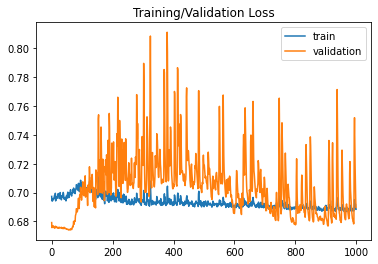

In [15]:
# Visualize the training and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title('Training/Validation Loss');
# Evaluate the model >> model.metrics_names
#print(f'{model.metrics_names}: {model.evaluate(Bitcoin_train, y_train , verbose=1)}')
plt.show()

# Save accuracies

In [16]:
y_prob = model.predict(X_test)
y_pred = list(map(lambda x: 0 if x<0.49 else 1, y_prob))

In [17]:
# Computing Accuracy, Precision and Recall
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.552930056710775


In [18]:
df_prediction = pd.read_csv("../data/model_accuracy_nsq.csv", index_col = False)
df_prediction =  df_prediction.drop(columns=["Unnamed: 0"])
df_prediction

,Unnamed: 0.2,Unnamed: 0.1,RF_pred,RF_accuracy,RF_prob,SVC_pred,SVC_accuracy,SVC_prob,XGB_pred,XGB_accuracy,...,LGBM_accuracy,LGBM_prob,y,kNN_pred,kNN_accuracy,kNN_prob,LSTM_price_accuracy,LogReg_pred,LogReg_accuracy,LogReg_prob
0,0,0,1,0.523629,0.657543,1,0.558601,0.544082,1,0.533081,...,0.529301,0.532322,0,0,0.482987,0.5,0.624764,1,0.52741,0.547267
1,1,1,0,0.523629,0.324182,1,0.558601,0.544076,0,0.533081,...,0.529301,0.518503,1,0,0.482987,0.5,0.624764,1,0.52741,0.553199
2,2,2,0,0.523629,0.496864,1,0.558601,0.545460,1,0.533081,...,0.529301,0.515129,1,1,0.482987,1.0,0.624764,1,0.52741,0.552663
3,3,3,1,0.523629,0.574333,1,0.558601,0.545009,1,0.533081,...,0.529301,0.531008,1,0,0.482987,0.5,0.624764,1,0.52741,0.545378
4,4,4,0,0.523629,0.421569,1,0.558601,0.543872,0,0.533081,...,0.529301,0.529314,0,0,0.482987,0.0,0.624764,1,0.52741,0.539814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053,1053,1053,1,0.523629,0.679418,1,0.558601,0.539406,1,0.533081,...,0.529301,0.510938,0,1,0.482987,1.0,0.624764,1,0.52741,0.610656
1054,1054,1054,1,0.523629,0.555801,1,0.558601,0.537904,1,0.533081,...,0.529301,0.511045,1,0,0.482987,0.5,0.624764,1,0.52741,0.580581
1055,1055,1055,1,0.523629,0.573323,1,0.558601,0.540966,1,0.533081,...,0.529301,0.509250,0,0,0.482987,0.0,0.624764,1,0.52741,0.534213
1056,1056,1056,1,0.523629,0.719503,1,0.558601,0.536726,1,0.533081,...,0.529301,0.510938,1,1,0.482987,1.0,0.624764,1,0.52741,0.515443


In [19]:
df_prediction["RNN_pred"] = y_pred
df_prediction["RNN_accuracy"] = [accuracy for x in range(len(y_pred))]
df_prediction["RNN_prob"] = y_prob

In [20]:
df_prediction

,Unnamed: 0.2,Unnamed: 0.1,RF_pred,RF_accuracy,RF_prob,SVC_pred,SVC_accuracy,SVC_prob,XGB_pred,XGB_accuracy,...,kNN_pred,kNN_accuracy,kNN_prob,LSTM_price_accuracy,LogReg_pred,LogReg_accuracy,LogReg_prob,RNN_pred,RNN_accuracy,RNN_prob
0,0,0,1,0.523629,0.657543,1,0.558601,0.544082,1,0.533081,...,0,0.482987,0.5,0.624764,1,0.52741,0.547267,1,0.55293,0.565578
1,1,1,0,0.523629,0.324182,1,0.558601,0.544076,0,0.533081,...,0,0.482987,0.5,0.624764,1,0.52741,0.553199,1,0.55293,0.564170
2,2,2,0,0.523629,0.496864,1,0.558601,0.545460,1,0.533081,...,1,0.482987,1.0,0.624764,1,0.52741,0.552663,1,0.55293,0.563898
3,3,3,1,0.523629,0.574333,1,0.558601,0.545009,1,0.533081,...,0,0.482987,0.5,0.624764,1,0.52741,0.545378,1,0.55293,0.565142
4,4,4,0,0.523629,0.421569,1,0.558601,0.543872,0,0.533081,...,0,0.482987,0.0,0.624764,1,0.52741,0.539814,1,0.55293,0.564979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053,1053,1053,1,0.523629,0.679418,1,0.558601,0.539406,1,0.533081,...,1,0.482987,1.0,0.624764,1,0.52741,0.610656,1,0.55293,0.558407
1054,1054,1054,1,0.523629,0.555801,1,0.558601,0.537904,1,0.533081,...,0,0.482987,0.5,0.624764,1,0.52741,0.580581,1,0.55293,0.502763
1055,1055,1055,1,0.523629,0.573323,1,0.558601,0.540966,1,0.533081,...,0,0.482987,0.0,0.624764,1,0.52741,0.534213,1,0.55293,0.540803
1056,1056,1056,1,0.523629,0.719503,1,0.558601,0.536726,1,0.533081,...,1,0.482987,1.0,0.624764,1,0.52741,0.515443,1,0.55293,0.520607


In [21]:
df_prediction.to_csv("../data/model_accuracy_nsq.csv")